In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"]="TRUE"
import pandas as pd
import pymoo
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch
import importlib
import numpy as np
from tqdm import trange,tqdm
import matplotlib.pyplot as plt
import datetime
import dill
import warnings
import glob
import textwrap
import imageio
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

/home/laplace/mambaforge-pypy3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
biked_generated = pd.read_csv('./imputation/generated_fender.csv', index_col=0)

In [52]:
biked_generated.drop(columns=['Unnamed: 0'], inplace=True)
biked_generated

,BB textfield,Seat tube length,Stack,Head tube upper extension2,Seat angle,CS textfield,FCD textfield,Seat tube extension2,Head tube lower extension2,Head angle,...,BRAZEonFDTYPE OHCLASS: FD9070F,DIRECTMOUNTFDTYPE OHCLASS: FDM771D,DIRECTMOUNTFDTYPE OHCLASS: FDM9000D,DIRECTMOUNTFDTYPE OHCLASS: FDM9025D,CLAMPFDTYPE OHCLASS: FD9000B,CLAMPFDTYPE OHCLASS: FDM9000L,spc type OHCLASS: 0,spc type OHCLASS: 1,spc type OHCLASS: 2,spc type OHCLASS: 3
0,70.0,522.9,565.6,24.4,76.0,405.0,595.0,22.9,49.2,73.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,70.0,522.9,565.6,24.4,76.0,405.0,595.0,22.9,49.2,73.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,70.0,522.9,565.6,24.4,76.0,405.0,595.0,22.9,49.2,73.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,70.0,522.9,565.6,24.4,76.0,405.0,595.0,22.9,49.2,73.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,70.0,522.9,565.6,24.4,76.0,405.0,595.0,22.9,49.2,73.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,70.0,514.8,565.6,33.5,74.5,405.0,585.0,48.8,50.5,74.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
96,70.0,514.8,565.6,33.5,74.5,405.0,585.0,48.8,50.5,74.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
97,70.0,514.8,565.6,33.5,74.5,405.0,585.0,48.8,50.5,74.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
98,70.0,514.8,565.6,33.5,74.5,405.0,585.0,48.8,50.5,74.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [18]:
biked = pd.read_csv('./BIKED/new_colored_biked_processed.csv', index_col=0)
biked

,BB textfield,Seat tube length,Stack,Head tube upper extension2,Seat angle,CS textfield,FCD textfield,Seat tube extension2,Head tube lower extension2,Head angle,...,BRAZEonFDTYPE OHCLASS: FD9070F,DIRECTMOUNTFDTYPE OHCLASS: FDM771D,DIRECTMOUNTFDTYPE OHCLASS: FDM9000D,DIRECTMOUNTFDTYPE OHCLASS: FDM9025D,CLAMPFDTYPE OHCLASS: FD9000B,CLAMPFDTYPE OHCLASS: FDM9000L,spc type OHCLASS: 0,spc type OHCLASS: 1,spc type OHCLASS: 2,spc type OHCLASS: 3
1,67.0,588.7,565.6,40.0,72.500,430.00,580.3,28.7,50.0,73.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-14.5,265.0,565.6,23.3,71.500,350.00,570.0,39.1,23.1,71.5,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,4.0,562.0,565.6,36.5,74.000,415.00,655.4,45.9,35.9,72.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,50.0,460.0,565.6,29.1,73.500,375.00,552.8,19.0,33.9,70.5,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,24.0,300.0,565.6,20.2,72.500,431.79,605.3,36.4,54.3,72.1,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124795,60.0,540.0,565.6,40.0,73.500,389.44,600.3,40.0,40.9,70.5,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
124796,60.0,570.0,561.9,28.3,73.501,440.00,610.0,60.0,36.9,72.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
124797,70.0,535.4,565.6,24.9,73.000,419.60,564.5,15.4,41.5,73.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
124798,57.0,542.8,565.6,24.8,75.000,400.00,552.1,12.8,35.8,77.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


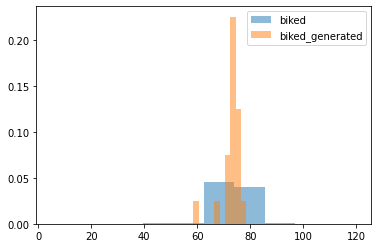

In [53]:
from scipy.stats import entropy
#Seat Angle
plt.hist(biked['Seat angle'], alpha=0.5, label='biked', density=True)
plt.hist(biked_generated['Seat angle'], alpha=0.5, label='biked_generated', density=True)
plt.legend(loc='upper right')
plt.show()



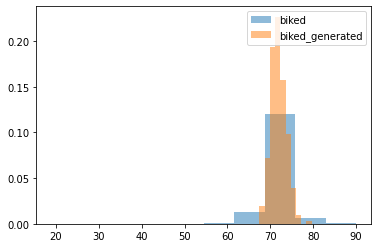

In [27]:
#Head Angle
plt.hist(biked['Head angle'], alpha=0.5, label='biked', density=True)
plt.hist(biked_generated['Head angle'], alpha=0.5, label='biked_generated', density=True)
plt.legend(loc='upper right')
plt.show()

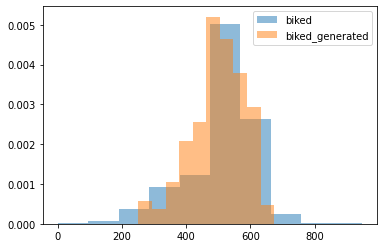

In [50]:
#Seat tube length
plt.hist(biked['Seat tube length'], alpha=0.5, label='biked', density=True)
plt.hist(biked_generated['Seat tube length'], alpha=0.5, label='biked_generated', density=True)
plt.legend(loc='upper right')
plt.show()


In [38]:
# get the column names that contain "Handlebar style"
handlebar_cols = list(filter(lambda x: 'bottle' in x, biked.columns))

# print the indices and names of the columns
for i, col in enumerate(handlebar_cols):
    print(f"Index: {i}, Name: {col}")


Index: 0, Name: bottle SEATTUBE0 WBX
Index: 1, Name: bottle SEATTUBE0 WBY
Index: 2, Name: bottle SEATTUBE0 CAGE
Index: 3, Name: bottle DOWNTUBE0 X
Index: 4, Name: bottle DOWNTUBE0 CAGE
Index: 5, Name: bottle DOWNTUBE0 WBY
Index: 6, Name: bottle DOWNTUBE0 WBX
Index: 7, Name: bottle SEATTUBE0 X
Index: 8, Name: bottle SEATTUBE0 show OHCLASS: False
Index: 9, Name: bottle SEATTUBE0 show OHCLASS: True
Index: 10, Name: bottle DOWNTUBE0 show OHCLASS: False
Index: 11, Name: bottle DOWNTUBE0 show OHCLASS: True


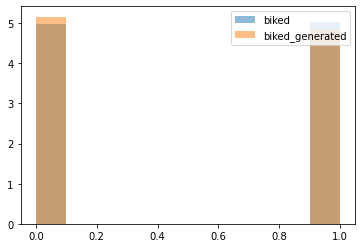

In [30]:
#Seat tube length
plt.hist(biked['Handlebar style OHCLASS: 0'], alpha=0.5, label='biked', density=True)
plt.hist(biked_generated['Handlebar style OHCLASS: 0'], alpha=0.5, label='biked_generated', density=True)
plt.legend(loc='upper right')
plt.show()


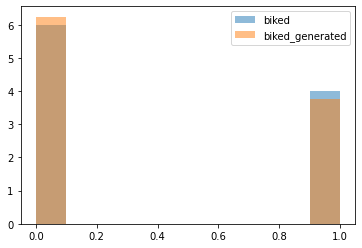

In [32]:
#Seat tube length
plt.hist(biked['Handlebar style OHCLASS: 1'], alpha=0.5, label='biked', density=True)
plt.hist(biked_generated['Handlebar style OHCLASS: 1'], alpha=0.5, label='biked_generated', density=True)
plt.legend(loc='upper right')
plt.show()

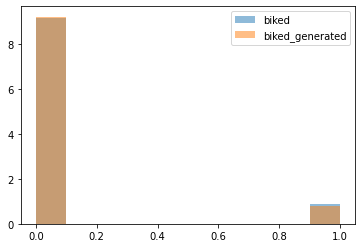

In [39]:
#Seat tube length
plt.hist(biked['bottle SEATTUBE0 show OHCLASS: True'], alpha=0.5, label='biked', density=True)
plt.hist(biked_generated['bottle SEATTUBE0 show OHCLASS: True'], alpha=0.5, label='biked_generated', density=True)
plt.legend(loc='upper right')
plt.show()


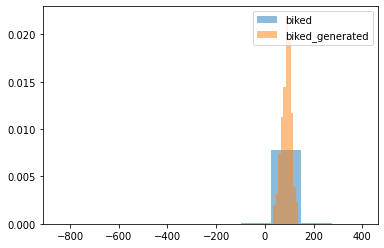

In [33]:
#Seat tube length
plt.hist(biked['Stem length'], alpha=0.5, label='biked', density=True)
plt.hist(biked_generated['Stem length'], alpha=0.5, label='biked_generated', density=True)
plt.legend(loc='upper right')
plt.show()